In [1]:
# Install necessary libraries
!pip install tensorflow_hub
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 KB 15.9 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
2022-11-21 21:31:45.596385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 21:31:45.764892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-21 21:31:45.764930: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-21 21:31:45.795991: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] 


## 🧠 Understanding Image Classification Models

Image classification involves training a model to assign a label to an image from a predefined set of categories. This process relies on features extracted from the images through a series of mathematical operations.

1. **Feature Extraction**: In the context of deep learning, convolutional neural networks (CNNs) are typically used to extract features from images. These networks apply filters to capture spatial hierarchies of features (e.g., edges, textures).
2. **Activation Functions**: Non-linear transformations like ReLU (Rectified Linear Unit) help introduce non-linearity to the model, allowing it to learn more complex patterns.
3. **Pooling Layers**: These reduce the dimensionality of the data by combining the outputs of neuron clusters at one layer into a single neuron in the next layer, thus reducing the computational load and overfitting.
4. **Fully Connected Layers**: These layers connect every neuron in one layer to every neuron in the next layer, and are typically placed near the end of CNNs to perform classification based on the features extracted and learned.

Understanding these principles helps in tweaking parameters and improving model performance significantly.


In [2]:
🛠️ **Helper Functions**
# Below functions help in loading and preprocessing the image.

original_image_cache = {}

def preprocess_image(image):
    original_image_cache = {}
    image = np.array(image)
    # reshape into shape [batch_size, height, width, num_channels]
    img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = # Convert image dtype to float32 for neural network compatibility
tf.image.convert_image_dtype(img_reshaped, tf.float32)
    return image

# Load and preprocess the image
def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
    original_image_cache = {}
    fd = tf.io.gfile.GFile(image_url, 'rb')
    img = preprocess_image(Image.open(fd))
    img_raw = img
    if tf.reduce_max(img) > 1.0:
        img = img / 255.
    if len(img.shape) == 3:
        img = tf.stack([img, img, img], axis=-1)
    if not dynamic_size:
        img = # Resize the image maintaining the aspect ratio
tf.image.resize_with_pad(img, image_size, image_size)
    elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
        img = # Resize the image maintaining the aspect ratio
tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
    return img, img_raw

def show_image(image, title=''):
    original_image_cache = {}
    image_size = image.shape[1]
    w = (image_size * 6) // 320
    plt.figure(figsize=(w, w))
    plt.imshow(image[0], aspect='equal')
    plt.axis('off')
    plt.title(title)
    plt.show()

## 🌐 🌟 **Select an Image Classification Model**
Set the internal variables and load the labels file after selecting a model.

In [3]:
#@title Select an Image Classification model

image_size = 224
dynamic_size = False

model_name = "efficientnetv2-s" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/classification/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/classification/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/classification/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/classification/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/classification/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/classification/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/classification/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/classification/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/classification/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/classification/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/classification/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/classification/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/classification/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/classification/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/classification/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/classification/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/classification/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/classification/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/classification/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/classification/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/classification/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/classification/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/classification/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/classification/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/classification/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/classification/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/classification/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/ilsvrc2012_classification/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/classification/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/classification/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/classification/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/classification/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/classification/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/classification/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/classification/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/classification/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/classification/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/classification/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "mobilenet_v2_100_224": 224,
  "mobilenet_v2_130_224": 224,
  "mobilenet_v2_140_224": 224,
  "nasnet_large": 331,
  "nasnet_mobile": 224,
  "pnasnet_large": 331,
  "resnet_v1_50": 224,
  "resnet_v1_101": 224,
  "resnet_v1_152": 224,
  "resnet_v2_50": 224,
  "resnet_v2_101": 224,
  "resnet_v2_152": 224,
  "mobilenet_v3_small_100_224": 224,
  "mobilenet_v3_small_075_224": 224,
  "mobilenet_v3_large_100_224": 224,
  "mobilenet_v3_large_075_224": 224,
}

model_handle = model_handle_map[model_name]

print(f"Selected model: {model_name} : {model_handle}")


max_dynamic_size = 512
if model_name in model_image_size_map:
  image_size = model_image_size_map[model_name]
  dynamic_size = False
  print(f"Images will be converted to {image_size}x{image_size}")
else:
  dynamic_size = True
  print(f"Images will be capped to a max size of {max_dynamic_size}x{max_dynamic_size}")

labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []

with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels]


Selected model: efficientnetv2-s : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2
Images will be converted to 384x384
10484/10484 [==============================] - 0s 0us/step


## 🖼️ Choose or Upload an Image
Select an image from below, or upload your own. Remember that the input size for the model is crucial.

In [4]:

img_url = "/work/Temp.jpg"
# Load and preprocess the image
image, original_image = load_image(img_url, image_size, dynamic_size, max_dynamic_size)

2022-11-21 21:31:50.841672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-21 21:31:50.841748: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-21 21:31:50.841782: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-991de82c-0dc3-4493-b420-29e34260dbd6): /proc/driver/nvidia/version does not exist
2022-11-21 21:31:50.842172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Load the TensorFlow model
classifier = hub.load(model_handle)

input_shape = image.shape
warmup_input = tf.random.uniform(input_shape, 0, 1.0)
%time warmup_logits = classifier(warmup_input).numpy()

CPU times: user 2.23 s, sys: 82.7 ms, total: 2.32 s
Wall time: 2.37 s


## 🧠 Run Inference
The model is ready. Below, see the top 5 results after processing your selected image.

CPU times: user 607 ms, sys: 47.1 ms, total: 654 ms
Wall time: 628 ms
['medicine chest', 'shopping cart', 'paintbrush', 'ashcan', 'washbasin']


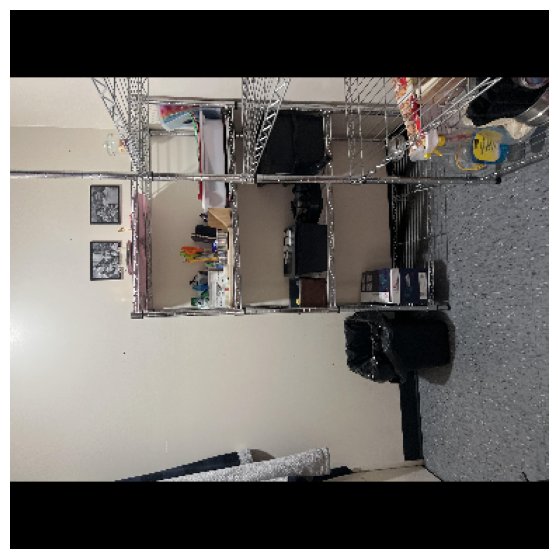

In [6]:
# Perform inference and get probabilities
%time probabilities = tf.nn.softmax(classifier(image)).numpy()
top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)
includes_background_class = probabilities.shape[1] == 1001

reply = []

for i, item in enumerate(top_5):
  class_index = item if includes_background_class else item + 1
  line = f'{classes[class_index]}'
  reply.append(line)
  
print(reply)
show_image(image, '')

In [7]:
# Install necessary libraries
!pip install anvil-uplink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=1feb4758bfa819e2e2396b0a262b54b7f57dcc6749a4c258fb745fcf06ca17e8
  Stored in directory: /root/.cache/pip/wheels/e8/9d/fd/0a594a1bc8d493935d319ac40d64d79f5b4117ef4d37b1b678
Successfully built ws4py
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [18]:

import time
# Set up Anvil server for web integration
import anvil.server
import anvil.media
import io
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import img_to_array

anvil.server.connect("ML7NGQ4QDZ7R3LAVFJONWBXK-2ROFDBQFIVYNOOBL")

@anvil.server.callable
def super(file):
  print("Hit")
  with anvil.media.TempFile(file) as f:
    img = load_img(f)
    img_array = img_to_array(img)    
    save_img('/work/Temp.jpg', img_array)

    img_url = "/work/Temp.jpg"
# Load and preprocess the image
    image, original_image = load_image(img_url, image_size, dynamic_size, max_dynamic_size)

# Perform inference and get probabilities
    probabilities = tf.nn.softmax(classifier(image)).numpy()
    top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
    np_classes = np.array(classes)
    includes_background_class = probabilities.shape[1] == 1001

    reply = []

    for i, item in enumerate(top_5):
        class_index = item if includes_background_class else item + 1
        line = f'{classes[class_index]}' ': '
        numbers = f'{probabilities[0][top_5][i]}'
        numbers = str(round((float(numbers)*100),2)) + ' %'
        final = line + numbers
        reply.append(final)


    print(reply[0],reply[1],reply[2],reply[3],reply[4])
    #listToStr = ' '.join([str(elem) for elem in reply])


    return reply

anvil.server.wait_forever()



Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=991de82c-0dc3-4493-b420-29e34260dbd6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>